In [1]:
using Distributions
using HypothesisTests
using Random
using StatsPlots
default(fmt=:png, tickfontsize=6, titlefontsize=12)

ECDF(A, x) = count(≤(x), A)/length(A)

function degree_of_freedom_Welch(m, sx², n, sy²)
    (sx²/m + sy²/n)^2 / ((sx²/m)^2/(m-1) + (sy²/n)^2/(n-1))
end

function plot_t_tests(;
        distx = Normal(),
        disty = Normal(),
        m = 10, 
        n = 10,
        s = 1,
        L = 10^6,
        ytick = 0:0.01:1,
        ylim = :auto,
        legend = :bottom,
        bin = :auto
    )
    println("(distribution of X) = distx = ", distx) 
    println("(distribution of Y) = disty = ", disty)
    println("(size of sample from X) = m = ", m)
    println("(size of sample from Y) = n = ", n)
    if s != 1 println("multiple of disty = ", s) end
    println()
    
    @show mean(distx)
    if s == 1 @show(mean(disty)) else @show(s*mean(disty)) end
    @show std(distx)
    if s == 1 @show(std(disty)) else @show(abs(s)*std(disty)) end
    println()
    
    T_Student = Vector{Float64}(undef, L)
    T_Welch = Vector{Float64}(undef, L)
    
    df_Student = m + n - 2
    DF_Welch = Vector{Float64}(undef, L)
    
    Xtmp = [Vector{eltype(distx)}(undef, m) for _ in 1:Threads.nthreads()]
    Ytmp = [Vector{eltype(disty)}(undef, n) for _ in 1:Threads.nthreads()]
    Threads.@threads for i in 1:L
        tid = Threads.threadid()
        X = rand!(distx, Xtmp[tid])
        Y = rand!(disty, Ytmp[tid])
    
        X̄ = mean(X)
        Ȳ = s*mean(Y)
        SX = std(X)
        SY = std(Y)
        S = √(((m-1)*SX^2 + (n-1)*SY^2)/(m+n-2))

        T_Student[i] = (X̄ - Ȳ)/(S*√(1/m + 1/n))
        T_Welch[i] = (X̄ - Ȳ)/√(SX^2/m + SY^2/n)
        
        DF_Welch[i] = degree_of_freedom_Welch(m, SX^2, n, SY^2)
    end
    @show T_Student ≈ T_Welch
    println()
    
    @show df_Student
    @show mean(DF_Welch) std(DF_Welch)
    println()

    pval_Student = @. 2ccdf(TDist(df_Student), abs(T_Student))
    pval_Welch = @. 2ccdf(TDist(DF_Welch), abs(T_Welch))

    @show ECDF(pval_Student, 0.05) ECDF(pval_Welch, 0.05)
    println()
    @show ECDF(pval_Student, 0.01) ECDF(pval_Welch, 0.01)
    println()
    
    P = plot(α -> ECDF(pval_Student, α), 0, 0.1; label="Student t-test")
    plot!(α -> ECDF(pval_Welch, α), 0, 0.1; label="Welch t-test", ls=:dash)
    plot!(identity, 0, 0.1; label="", ls=:dot, c=:black)
    plot!(; xtick=0:0.01:1, ytick, xrotation=90)
    plot!(; xguide="nominal significance level α",
        yguide="probability of p-value ≤ α")
    plot!(; legend=:outertop, legendfontsize=10)

    Q = stephist(pval_Student; norm=true, bin, label="Student t-test")
    stephist!(pval_Welch; norm=true, bin, ls=:dash, label="Welch t-test")
    plot!(; xguide="P-value", yguide="probability density")
    plot!(; xtick=0:0.05:1, ytick=0:0.1:5, xrotation=90)
    plot!(; legend=:outertop, legendfontsize=10, ylim)
    
    plot(P, Q; size=(1000, 460), layout=@layout [a{0.4w} b])
    plot!(; bottommargin=4Plots.mm, leftmargin=4Plots.mm)
end

function plot_df_and_tstatratio(;
        m = 9,
        n = 11,
        tick = Any[0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
    )
    log10tick = (tick, string.(tick))
    as = 10.0 .^ range(log10(minimum(tick)), log10(maximum(tick)), 1000)

    P = plot(as, a -> degree_of_freedom_Welch(m, 1, n, a^2); label="Welch t-test")
    hline!([(m-1)+(n-1)]; label="Student t-test", ls=:dash)
    hline!([min(m-1, n-1)]; label="min(m-1, n-1)", ls=:dashdot)
    hline!([max(m-1, n-1)]; label="max(m-1, n-1)", ls=:dashdotdot)
    vline!([√((n*(n-1))/(m*(m-1)))]; label="√((n*(n-1))/(m*(m-1)))", ls=:dot)
    vline!([1]; label="", ls=:dot, c=:gray)
    plot!(xscale=:log10, xtick=log10tick)
    plot!(xguide="std(sample of Y) / std(sample of X)")
    title!("degree of freedom for m = $m, n = $n")

    Q = plot(as, a -> √(1/m + a^2/n) / √((((m-1)+(n-1)*a^2)/(m-1+n-1))*(1/m+1/n));
        label="t_Student / t_Welch")
    hline!([√(m/n), √(n/m)]; label="√(m/n), √(n/m)", ls=:dash)
    vline!([1]; label="", ls=:dot, c=:gray)
    plot!(xscale=:log10, xtick=log10tick)
    plot!(xguide="std(sample of Y) / std(sample of X)")
    plot!(ylim=(0.9, 1.1) .* minmax(√(m/n), √(n/m)))
    title!("t_Student / t_Welch for m = $m,  n = $n")

    plot(P, Q; size=(1000, 400))
    plot!(bottommargin=4Plots.mm)
end

plot_df_and_tstatratio (generic function with 1 method)

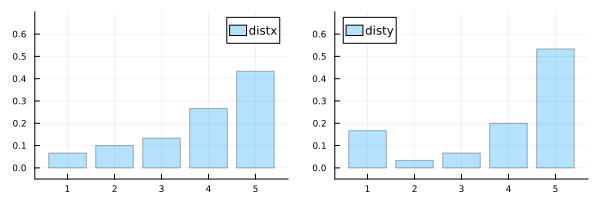

(distribution of X) = distx = Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(5)
p: [0.06666666666666667, 0.1, 0.13333333333333333, 0.26666666666666666, 0.43333333333333335]
)

(distribution of Y) = disty = Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(5)
p: [0.16666666666666666, 0.03333333333333333, 0.06666666666666667, 0.2, 0.5333333333333333]
)

(size of sample from X) = m = 100
(size of sample from Y) = n = 70

mean(distx) = 3.9000000000000004
mean(disty) = 3.9
std(distx) = 1.2476644848141933
std(disty) = 1.491084616423003

T_Student ≈ T_Welch = false

df_Student = 168
mean(DF_Welch) = 131.59026080783804
std(DF_Welch) = 9.98683445823737

ECDF(pval_Student, 0.05) = 0.057734
ECDF(pval_Welch, 0.05) = 0.05092

ECDF(pval_Student, 0.01) = 0.012795
ECDF(pval_Welch, 0.01) = 0.010852



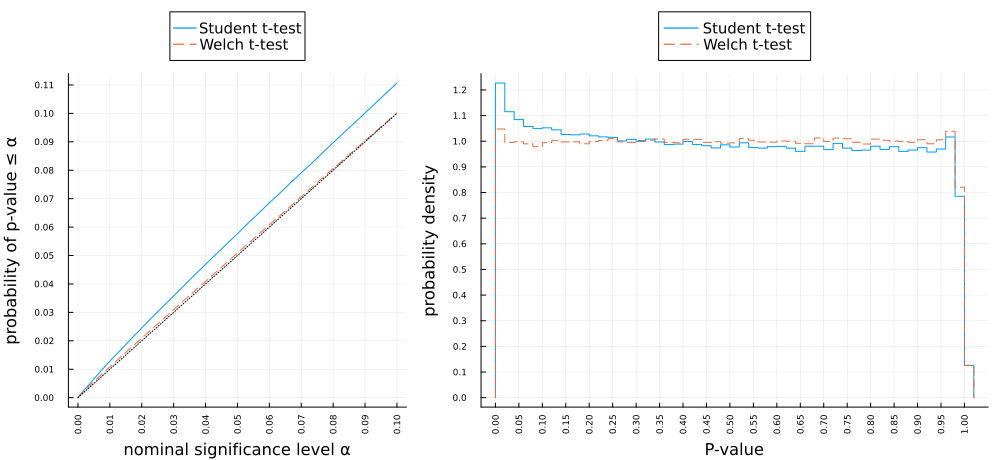

In [2]:
fx = [2, 3, 4, 8, 13]
px = fx / sum(fx)
distx = Categorical(px)

fy = [5, 1, 2, 6, 16]
py = fy / sum(fy)
disty = Categorical(py)

P = bar(distx; alpha=0.3, label="distx", ylim=(-0.05, 0.7))
Q = bar(disty; alpha=0.3, label="disty", ylim=(-0.05, 0.7))
plot(P, Q; size=(600, 200)) |> display

plot_t_tests(; distx, disty, m=100, n=70, bin=50)

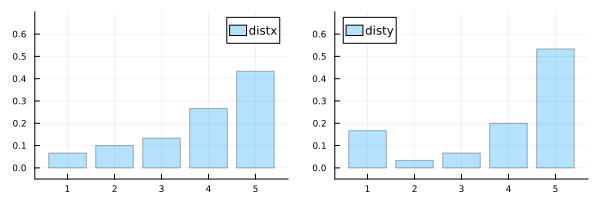

(distribution of X) = distx = Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(5)
p: [0.06666666666666667, 0.1, 0.13333333333333333, 0.26666666666666666, 0.43333333333333335]
)

(distribution of Y) = disty = Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(5)
p: [0.16666666666666666, 0.03333333333333333, 0.06666666666666667, 0.2, 0.5333333333333333]
)

(size of sample from X) = m = 50
(size of sample from Y) = n = 35

mean(distx) = 3.9000000000000004
mean(disty) = 3.9
std(distx) = 1.2476644848141933
std(disty) = 1.491084616423003

T_Student ≈ T_Welch = false

df_Student = 83
mean(DF_Welch) = 64.99822323501412
std(DF_Welch) = 6.922361406902791

ECDF(pval_Student, 0.05) = 0.058077
ECDF(pval_Welch, 0.05) = 0.051947

ECDF(pval_Student, 0.01) = 0.012927
ECDF(pval_Welch, 0.01) = 0.011608



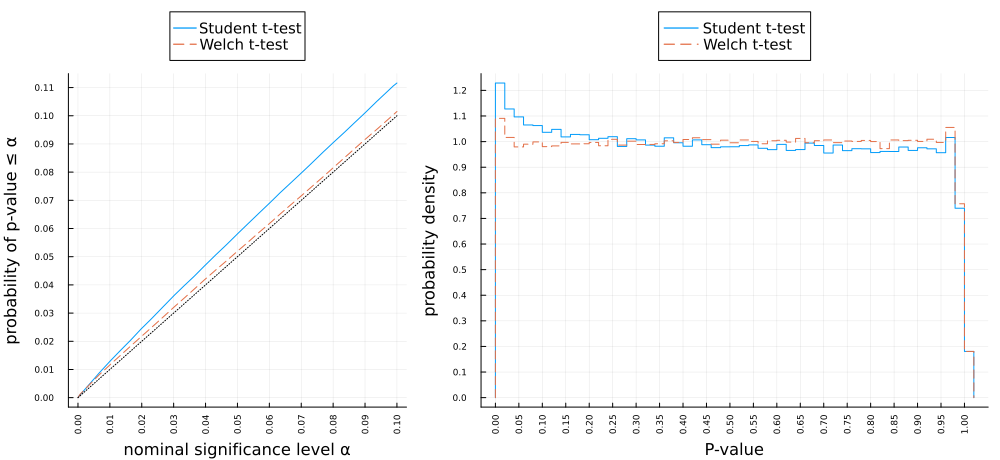

In [3]:
fx = [2, 3, 4, 8, 13]
px = fx / sum(fx)
distx = Categorical(px)

fy = [5, 1, 2, 6, 16]
py = fy / sum(fy)
disty = Categorical(py)

P = bar(distx; alpha=0.3, label="distx", ylim=(-0.05, 0.7))
Q = bar(disty; alpha=0.3, label="disty", ylim=(-0.05, 0.7))
plot(P, Q; size=(600, 200)) |> display

plot_t_tests(; distx, disty, m=50, n=35, bin=50)

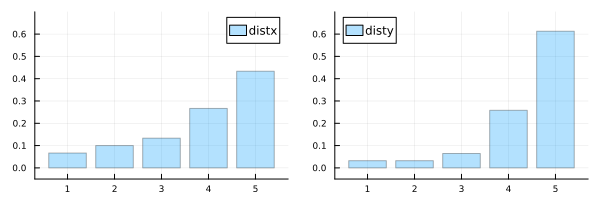

(distribution of X) = distx = Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(5)
p: [0.06666666666666667, 0.1, 0.13333333333333333, 0.26666666666666666, 0.43333333333333335]
)

(distribution of Y) = disty = Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(5)
p: [0.03225806451612903, 0.03225806451612903, 0.06451612903225806, 0.25806451612903225, 0.6129032258064516]
)

(size of sample from X) = m = 100
(size of sample from Y) = n = 70

mean(distx) = 3.9000000000000004
mean(disty) = 4.387096774193548
std(distx) = 1.2476644848141933
std(disty) = 0.9731034276773133

T_Student ≈ T_Welch = false

df_Student = 168
mean(DF_Welch) = 162.67418826505667
std(DF_Welch) = 6.153616194465843

ECDF(pval_Student, 0.05) = 0.787505
ECDF(pval_Welch, 0.05) = 0.802985

ECDF(pval_Student, 0.01) = 0.558938
ECDF(pval_Welch, 0.01) = 0.599079



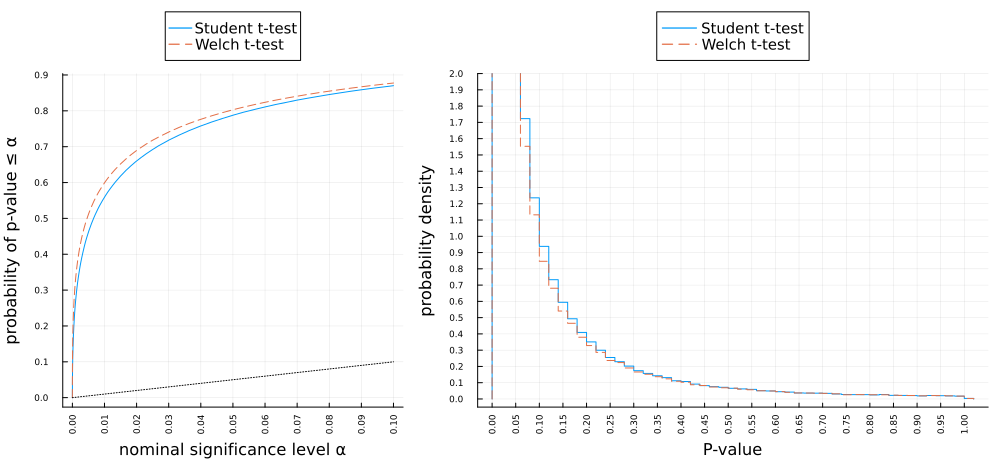

In [4]:
fx = [2, 3, 4, 8, 13]
px = fx / sum(fx)
distx = Categorical(px)

fy = [1, 1, 2, 8, 19]
py = fy / sum(fy)
disty = Categorical(py)

P = bar(distx; alpha=0.3, label="distx", ylim=(-0.05, 0.7))
Q = bar(disty; alpha=0.3, label="disty", ylim=(-0.05, 0.7))
plot(P, Q; size=(600, 200)) |> display

plot_t_tests(; distx, disty, m=100, n=70, ytick=0:0.1:1, ylim=(-0.05, 2), bin=50)

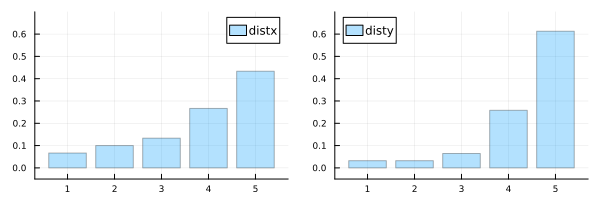

(distribution of X) = distx = Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(5)
p: [0.06666666666666667, 0.1, 0.13333333333333333, 0.26666666666666666, 0.43333333333333335]
)

(distribution of Y) = disty = Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(5)
p: [0.03225806451612903, 0.03225806451612903, 0.06451612903225806, 0.25806451612903225, 0.6129032258064516]
)

(size of sample from X) = m = 50
(size of sample from Y) = n = 35

mean(distx) = 3.9000000000000004
mean(disty) = 4.387096774193548
std(distx) = 1.2476644848141933
std(disty) = 0.9731034276773133

T_Student ≈ T_Welch = false

df_Student = 83
mean(DF_Welch) = 78.72638369538478
std(DF_Welch) = 4.739894096488558

ECDF(pval_Student, 0.05) = 0.486447
ECDF(pval_Welch, 0.05) = 0.521912

ECDF(pval_Student, 0.01) = 0.242413
ECDF(pval_Welch, 0.01) = 0.295756



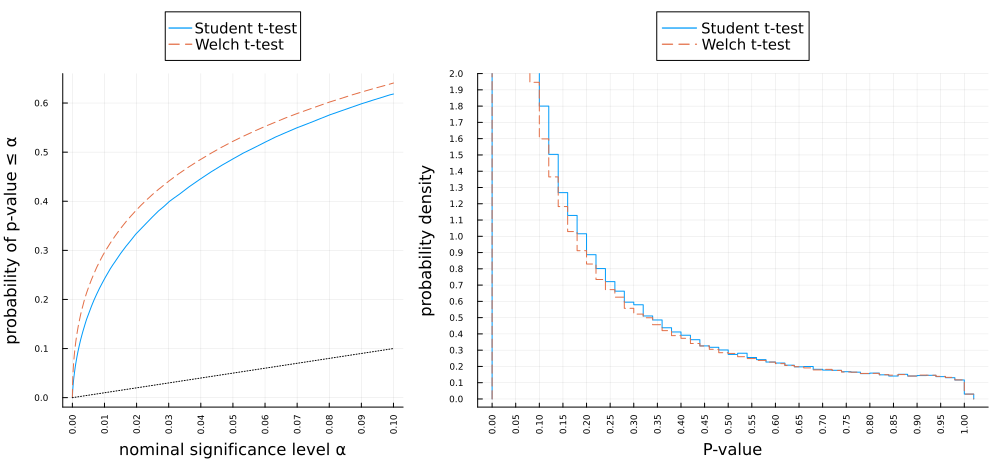

In [5]:
fx = [2, 3, 4, 8, 13]
px = fx / sum(fx)
distx = Categorical(px)

fy = [1, 1, 2, 8, 19]
py = fy / sum(fy)
disty = Categorical(py)

P = bar(distx; alpha=0.3, label="distx", ylim=(-0.05, 0.7))
Q = bar(disty; alpha=0.3, label="disty", ylim=(-0.05, 0.7))
plot(P, Q; size=(600, 200)) |> display

plot_t_tests(; distx, disty, m=50, n=35, ytick=0:0.1:1, ylim=(-0.05, 2), bin=50)

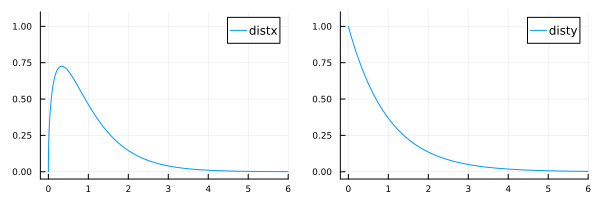

(distribution of X) = distx = Gamma{Float64}(α=1.5, θ=0.6666666666666666)
(distribution of Y) = disty = Exponential{Float64}(θ=1.0)
(size of sample from X) = m = 50
(size of sample from Y) = n = 35

mean(distx) = 1.0
mean(disty) = 1.0
std(distx) = 0.816496580927726
std(disty) = 1.0

T_Student ≈ T_Welch = false

df_Student = 83
mean(DF_Welch) = 64.77035139145656
std(DF_Welch) = 10.879346124602906

ECDF(pval_Student, 0.05) = 0.057409
ECDF(pval_Welch, 0.05) = 0.052395

ECDF(pval_Student, 0.01) = 0.011588
ECDF(pval_Welch, 0.01) = 0.011555



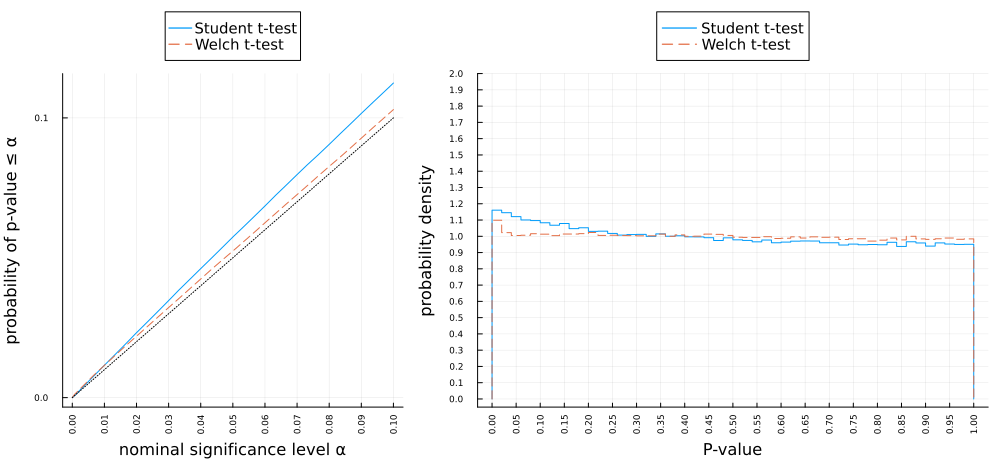

In [6]:
distx = Gamma(1.5, 1/1.5)
disty = Exponential()

P = plot(distx; label="distx", xlim=(-0.2, 6), ylim=(-0.05, 1.1))
Q = plot(disty; label="disty", xlim=(-0.2, 6), ylim=(-0.05, 1.1))
plot(P, Q; size=(600, 200)) |> display

plot_t_tests(; distx, disty, m=50, n=35, ytick=0:0.1:1, ylim=(-0.05, 2), bin=50)

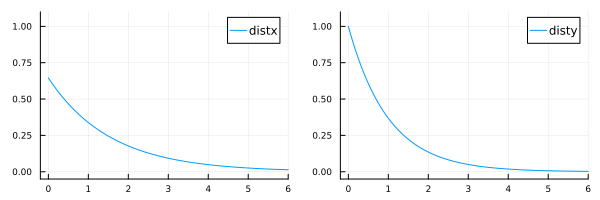

(distribution of X) = distx = Exponential{Float64}(θ=1.55)
(distribution of Y) = disty = Exponential{Float64}(θ=1.0)
(size of sample from X) = m = 50
(size of sample from Y) = n = 35

mean(distx) = 1.55
mean(disty) = 1.0
std(distx) = 1.55
std(disty) = 1.0

T_Student ≈ T_Welch = false

df_Student = 83
mean(DF_Welch) = 77.71864958880994
std(DF_Welch) = 5.710107757694452

ECDF(pval_Student, 0.05) = 0.451479
ECDF(pval_Welch, 0.05) = 0.516805

ECDF(pval_Student, 0.01) = 0.187104
ECDF(pval_Welch, 0.01) = 0.269129



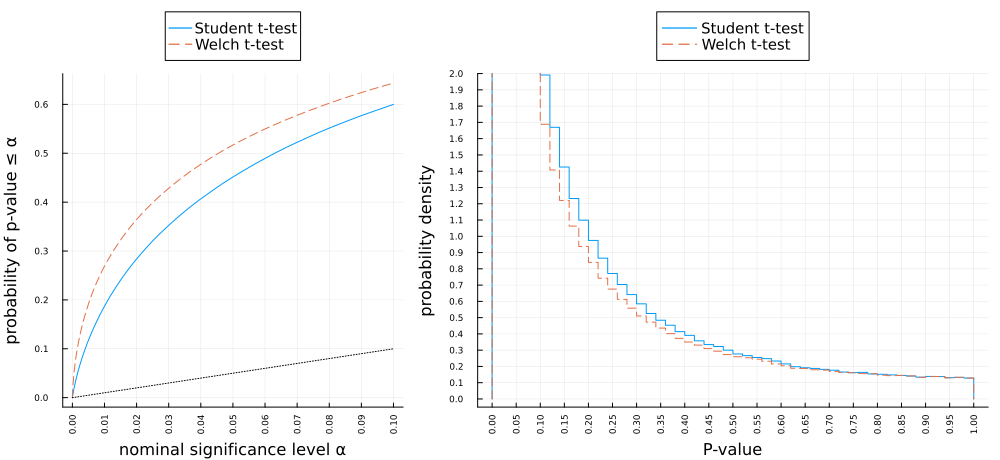

In [7]:
distx = Exponential(1.55)
disty = Exponential()

P = plot(distx; label="distx", xlim=(-0.2, 6), ylim=(-0.05, 1.1))
Q = plot(disty; label="disty", xlim=(-0.2, 6), ylim=(-0.05, 1.1))
plot(P, Q; size=(600, 200)) |> display

plot_t_tests(; distx, disty, m=50, n=35, ytick=0:0.1:1, ylim=(-0.05, 2), bin=50)

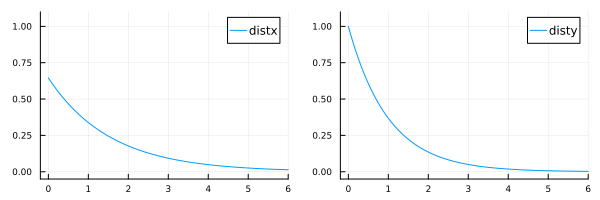

(distribution of X) = distx = Exponential{Float64}(θ=1.55)
(distribution of Y) = disty = Exponential{Float64}(θ=1.0)
(size of sample from X) = m = 100
(size of sample from Y) = n = 70

mean(distx) = 1.55
mean(disty) = 1.0
std(distx) = 1.55
std(disty) = 1.0

T_Student ≈ T_Welch = false

df_Student = 168
mean(DF_Welch) = 161.3290094393012
std(DF_Welch) = 7.701529472723216

ECDF(pval_Student, 0.05) = 0.774859
ECDF(pval_Welch, 0.05) = 0.808033

ECDF(pval_Student, 0.01) = 0.51535
ECDF(pval_Welch, 0.01) = 0.594025



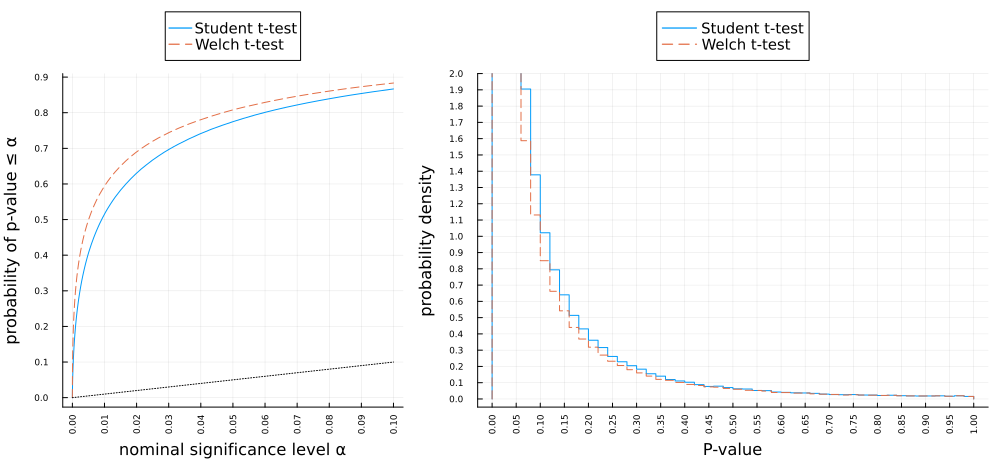

In [8]:
distx = Exponential(1.55)
disty = Exponential()

P = plot(distx; label="distx", xlim=(-0.2, 6), ylim=(-0.05, 1.1))
Q = plot(disty; label="disty", xlim=(-0.2, 6), ylim=(-0.05, 1.1))
plot(P, Q; size=(600, 200)) |> display

plot_t_tests(; distx, disty, m=100, n=70, ytick=0:0.1:1, ylim=(-0.05, 2), bin=50)